Goodness-of-fit: 
========= ============= ============= ===================== ======= 
 Dataset   Noise level   Reduced 𝛘2    Residual autocorr.    RMSD   
========= ============= ============= ===================== ======= 
   #1         0.015         1.012             0.179          0.015  
========= ============= ============= ===================== ======= 
Model hyperparameters: 
 Regularization parameter  
          0.265            
Model parameters: 
=========== ======= ========================= ====== ====================================== 
 Parameter   Value   95%-Confidence interval   Unit   Description                           
=========== ======= ========================= ====== ====================================== 
 reftime     0.400   (0.399,0.400)              μs    Refocusing time of pathway #1         
 decay       0.021   (0.018,0.024)             μs⁻¹   Decay rate                            
 stretch     1.977   (1.894,2.061)                    Stretch factor     

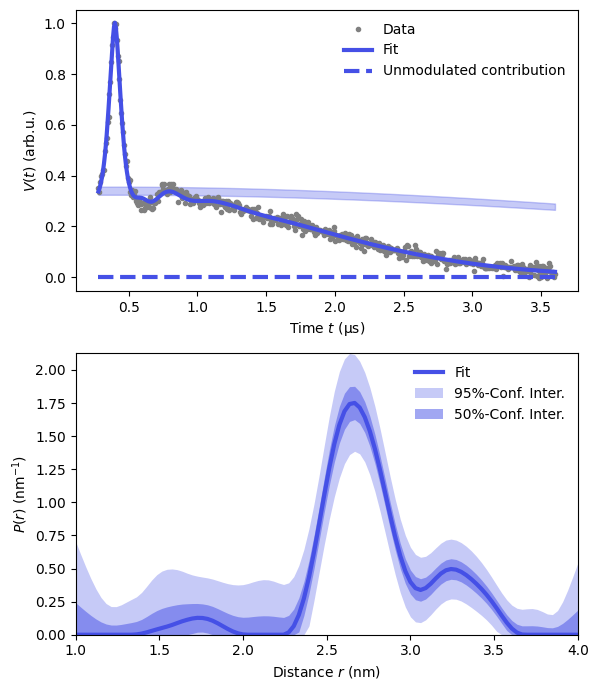

In [27]:
import numpy as np 
import deerlab as dl 
import matplotlib.pyplot as plt 

path = '../data/'
file = 'example_5pridme_overtones.DTA'

tau1 = 0.4
tau2 = 3.2
tmin = 0.28

# Load the experimental data
t,Vexp = dl.deerload(path + file)

# Pre-processing
Vexp = Vexp/np.max(Vexp)     # Rescaling (aesthetic)
t = t + tmin                # Account for time axis shift

r = np.linspace(1, 4, 100) # nm
pulselength = 0.024 # us

# Construct the experiment with overtones
Novertones = 3 # we expect 3 dipolar overtones
Ps = np.array([0.4, 0.5, 0.1]) # normalized overtone coefficients (user input)
Ps /= sum(Ps)

# Building an extended RIDME model allowing higher harmonics.
def reftimes(tau1,tau2):
    return [tau1]*Novertones
# Pulse delays 
delays = [tau1,tau2]
# Theoretical dipolar harmonics
harmonics = list(range(1,Novertones+1))
# Harmonics labels
pathwaylabels = np.arange(1,len(harmonics)+1)

my_ridme = dl.ExperimentInfo('5-pulse RIDME with overtones', 
                             reftimes, 
                             harmonics, 
                             pulselength, 
                             pathwaylabels, 
                             delays
                             )

Vmodel = dl.dipolarmodel(t, r, Bmodel=dl.bg_strexp, experiment=my_ridme)

# Linking refocusing times of different overtones
Vmodel = dl.link(Vmodel, reftime=[f'reftime{n+1}' for n in range(Novertones)])
# Introducing a total modulation depth lam = lam1 + lam2 + lam3
Vmodel.addnonlinear(key='lam', 
                    lb=0, 
                    ub=1, 
                    par0=0.1, 
                    name='Modulation depth', 
                    unit='', 
                    description='Overall modulation depth'
                    )
# Fixing ratios of overtones
Vmodel = dl.relate(Vmodel, 
                   lam1=lambda lam: lam*Ps[0], 
                   lam2=lambda lam: lam*Ps[1], 
                   lam3=lambda lam: lam*Ps[2]
                   )

# Fit the model to the data
results = dl.fit(Vmodel, Vexp)

# Print a results summary
print(results)

# Extract fitted dipolar signal
Vfit = results.model

# Extract fitted distance distribution
Pfit = results.P
Pci95 = results.PUncert.ci(95)
Pci50 = results.PUncert.ci(50)

# Extract the unmodulated contribution
Bfcn = lambda lam,decay,stretch,reftime: results.P_scale*(1-lam)*dl.bg_strexp(t-reftime,decay,stretch)
Bfit = results.evaluate(Bfcn)
Bci = results.propagate(Bfcn).ci(95)

plt.figure(figsize=[6,7])
violet = '#4550e6'
plt.subplot(211)
# Plot experimental and fitted data
plt.plot(t,Vexp,'.',color='grey',label='Data')
plt.plot(t,Vfit,linewidth=3,color=violet,label='Fit')
plt.plot(t,Bfit,'--',linewidth=3,color=violet,label='Unmodulated contribution')
plt.fill_between(t,Bci[:,0],Bci[:,1],color=violet,alpha=0.3)
plt.legend(frameon=False,loc='best')
plt.xlabel('Time $t$ (μs)')
plt.ylabel('$V(t)$ (arb.u.)')
# Plot the distance distribution
plt.subplot(212)
plt.plot(r,Pfit,color=violet,linewidth=3,label='Fit')
plt.fill_between(r,Pci95[:,0],Pci95[:,1],alpha=0.3,color=violet,label='95%-Conf. Inter.',linewidth=0)
plt.fill_between(r,Pci50[:,0],Pci50[:,1],alpha=0.5,color=violet,label='50%-Conf. Inter.',linewidth=0)
plt.legend(frameon=False,loc='best')
plt.autoscale(enable=True, axis='both', tight=True)
plt.xlabel('Distance $r$ (nm)')
plt.ylabel('$P(r)$ (nm$^{-1}$)')
plt.tight_layout()
plt.show()